In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

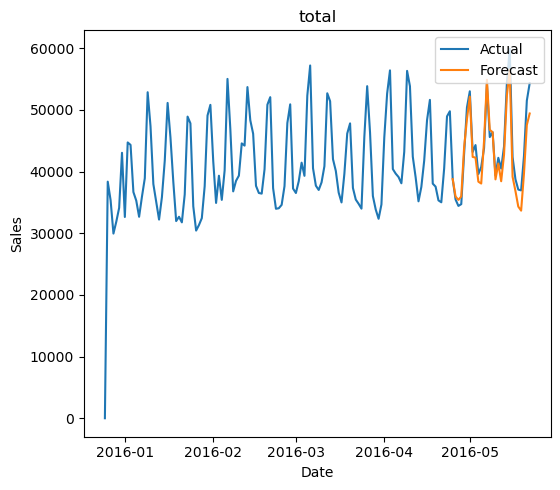

In [2]:
level_idx = 1

estimator = 'DeepState'
ids = np.empty((0, ))
test_labels = np.empty((0, 28))
test_forecasts = np.empty((0, 28))

for level in range(level_idx, level_idx+1):
    level_dir = f"../result/level {level}"
    for model_dir in os.listdir(level_dir):
        if model_dir.startswith(estimator):
            model_path = os.path.join(level_dir, model_dir)
            if os.path.isdir(model_path):
                for root, dirs, files in os.walk(model_path):
                    for file in files:
                        if file.startswith('test_labels'):
                            with open(os.path.join(root, file), 'rb') as pickle_file:
                                test_labels = pd.read_pickle(pickle_file)
                        if file.startswith('test_forecasts'):
                            with open(os.path.join(root, file), 'rb') as pickle_file:
                                test_forecasts = pd.read_pickle(pickle_file)
    
    page = 0
    graphs_per_page = 25

    start_idx = page * graphs_per_page
    end_idx = start_idx + graphs_per_page

    num_plots = min(len(test_labels[start_idx:end_idx]), graphs_per_page)
    cols = 5
    rows = (num_plots + cols - 1) // cols 
    fig, axes = plt.subplots(rows, cols, figsize=(25, 5 * rows))

    for i in range(num_plots):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        
        ax.plot(test_labels[start_idx + i][-150:].to_timestamp(), label="Actual")
        ax.plot(pd.Series(test_forecasts[start_idx + i].quantile(0.5), index=test_forecasts[start_idx + i].start_date.to_timestamp() + pd.to_timedelta(range(len(test_forecasts[0].quantile(0.5))), unit='D')), label="Forecast")
        ax.set_title(f'{test_forecasts[start_idx + i].item_id}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        ax.legend(loc="upper right")

    for j in range(num_plots, rows * cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()
    plt.close()

In [67]:
import os
import time
import pickle
import copy
import gc
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from gluonts.dataset.field_names import FieldName
from gluonts.evaluation import make_evaluation_predictions
from gluonts.model.predictor import Predictor

def highlight_print(message, color='blue'):
    colors = {
        'blue': '\033[94m',
        'green': '\033[92m',
        'red': '\033[91m',
        'end': '\033[0m'
    }
    print(f"{colors.get(color, colors['blue'])}{message}{colors['end']}")

def ensure_1d_array(arr):
    """
    배열이 1D가 되도록 보장
    """
    # numpy 배열로 변환
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)
    
    # 2D 배열인 경우 1D로 변환
    if arr.ndim > 1:
        return arr.flatten()
    
    return arr

def sliding_window_prediction(predictor, original_data, normalizer):
    """
    슬라이딩 윈도우 방식으로 전체 시계열 예측
    """
    # 초기 데이터 복사 및 처리
    initial_data = copy.deepcopy(original_data)
    
    # 초기 타겟 데이터 가져오기
    # target = initial_data['target']
    print(initial_data)

    # # 원본 데이터 길이 확인
    # initial_length = len(initial_data)

    # # 전체 예측 시계열 초기화
    # full_predictions = np.zeros(initial_length)
    # full_predictions[:28] = original_data[:28]
    
    # # 예측 수행 위치 추적
    # current_idx = 28
    
    # # 전체 시계열을 채울 때까지 반복
    # while current_idx < original_length:
    #     # 현재 사용 가능한 데이터 추출
    #     available_length = min(current_idx, 28)
    #     pred_data = original_data[:current_idx+available_length]

    #     # 예측 수행
    #     forecast_it, _ = make_evaluation_predictions(
    #         dataset=[pred_data],
    #         predictor=predictor,
    #     )
    #     forecast = list(forecast_it)
    #     break
        
    #     # 예측값 추출
    #     pred_values = forecast.quantile(0.5)
        
    #     # 역정규화
    #     denorm_values = normalizer.inverse_transform_labels(pred_values)
    #     pred_values = denorm_values
        
    #     # 예측값 저장
    #     next_end = min(current_idx + len(pred_values), total_length)
    #     next_length = next_end - current_idx
    #     full_predictions[current_idx:next_end] = pred_values[:next_length]
        
    #     # 다음 위치로 이동
    #     current_idx = next_end

    # return full_predictions

def predict_full_series_with_pretrained_model(level_idx, model_name):
    """
    사전 훈련된 모델을 사용하여 전체 시계열 예측 수행
    """
    # 폴더 경로 설정
    base_dir = '../result'
    level_dir = os.path.join(base_dir, f'level {level_idx}')
    
    # 정확한 모델 디렉토리 찾기
    model_dirs = [d for d in os.listdir(level_dir) if d.startswith(model_name)]
    if not model_dirs:
        raise ValueError(f"모델 '{model_name}'을 찾을 수 없습니다.")
    model_dir = os.path.join(level_dir, model_dirs[0])
    
    # 결과 저장 디렉토리 생성
    forecast_dir = os.path.join(model_dir, 'full_forecasts')
    os.makedirs(forecast_dir, exist_ok=True)

    # 데이터셋 로드
    highlight_print(f"\n========== Level {level_idx} ==========")
    print(f"Loading dataset...", end=' ')
    dataset_start = time.time()
    with open(os.path.join('../dataset/else', f'dataset_level_{level_idx}.pkl'), 'rb') as f:
        dataset = pickle.load(f)
    print(f"{(time.time() - dataset_start)/60:.1f} minutes")
    
    # 데이터셋 정규화
    print("Normalizing dataset...", end=' ')
    normalize_start = time.time()
    with open(os.path.join(level_dir, 'normalizer.pkl'), 'rb') as f:
        normalizer = pickle.load(f)
    norm_train_dataset = normalizer.transform(dataset['train'])
    print(f"{(time.time() - normalize_start)/60:.1f} minutes")
    
    # 훈련된 모델 로드
    highlight_print(f"\n---------- {model_name} ----------")
    model_load_start = time.time()
    predictor = Predictor.deserialize(Path(model_dir))
    print(f"{(time.time() - model_load_start)/60:.1f} minutes")
    
    # 결과 저장용 리스트
    forecasts = []
    
    # 각 시리즈에 대해 전체 예측 수행
    for series_dataset in norm_train_dataset:  # 훈련 데이터셋만 처리
        # 항목 ID 가져오기
        item_id = series_dataset['item_id']

        # 시작 날짜 가져오기
        start_date = series_dataset['start']

        # 원본 데이터 가져오기
        original_data = copy.deepcopy(series_dataset['target'])

        # 슬라이딩 윈도우 예측 수행
        predicted_series = sliding_window_prediction(
            predictor=predictor,
            original_data=original_data,
            normalizer=normalizer
        )
        break
        # 결과 저장
        result = {
            'item_id': item_id,
            'start_date': start_date,
            'predictions': predicted_series,
            'actuals': original_target_denorm,  # 실제값도 저장
            'prediction_time': time.time() - start_time
        }
        
        forecasts.append(result)
        
        # 결과 시각화
        plt.figure(figsize=(16, 8))
        
        # 날짜 범위 생성
        time_axis = pd.date_range(start=start_date, periods=total_length)
        time_axis_np = time_axis.to_numpy()
        
        # 실제값 플롯 (numpy 배열로 변환)
        plt.plot(
            time_axis_np,
            ensure_1d_array(original_target_denorm), 
            label='Actual', 
            color='blue', 
            linewidth=1
        )
        
        # 예측값 플롯 (numpy 배열로 변환)
        plt.plot(
            time_axis_np,
            ensure_1d_array(predicted_series), 
            label='Predicted (full series)', 
            color='red', 
            linewidth=1, 
            linestyle='--'
        )
        
        plt.title(f'Full Series Prediction for {item_id}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()  # 범례 추가
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.savefig(os.path.join(forecast_dir, f'forecasts_{series_idx+1}.png'))
        plt.close()  
        
    # 전체 결과 저장
    with open(os.path.join(forecast_dir, 'forecasts.pkl'), "wb") as f:
        pickle.dump(forecasts, f)


# 실행 예시
models = [
    {'level_idx': 2, 'model_name': 'DeepAR'},
]

try:
    for model_config in models:
        predict_full_series_with_pretrained_model(
            level_idx=model_config['level_idx'], 
            model_name=model_config['model_name']
        )
except Exception as e:
    print(f"Error: {str(e)}")
    import traceback
    traceback.print_exc()


========== Level 2 ==========
Loading dataset... 0.0 minutes
Normalizing dataset... 0.0 minutes

---------- DeepAR ----------
0.0 minutes
[0.5627404 0.5472783 0.4007057 ... 0.7411093 0.9430282 0.8442691]
